## QPEを使った基底エネルギーの計算

In [1]:
# まず必要なモジュールをインポートする
import sys
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# ワークブック独自のモジュール
from qc_workbook.hamiltonian import make_hamiltonian
from qc_workbook.show_state import show_state

print('notebook ready')

notebook ready


/var/folders/28/2gtcygh52lg84810q56wh9y80000gn/T/ipykernel_78809/1891917289.py:54: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  for idx, amp in enumerate(state):


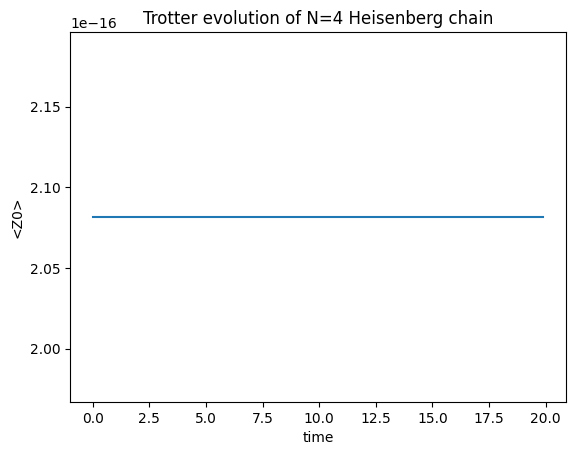

In [9]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Nスピンのハイゼンベルク鎖
def trotter_step(qc, delta_t, J=1.0, delta=1.0, N=4):
    for i in range(N-1):
        qc.rxx(2 * J * delta_t, i, i+1)
        qc.ryy(2 * J * delta_t, i, i+1)
        qc.rzz(2 * J * delta_t * delta, i, i+1)

# 初期状態: 全部|+> (スピンx方向)
def initial_state(N):
    qc = QuantumCircuit(N)
    for i in range(N):
        qc.h(i)
    return qc

# シミュレーションパラメータ
N = 4
time_steps = 200
delta_t = 0.1
times = np.arange(0, time_steps*delta_t, delta_t)

# 状態の初期化
qc = initial_state(N)

qc.save_statevector()

# 時間発展しながらZ測定
#backend = Aer.get_backend('statevector_simulator')
simulator = AerSimulator()
#circuit = transpile(circuit, backend=simulator)
#job = simulator.run(circuit, shots=10000)

expectations = []

for t in times:
    # 1 step Trotter evolution
    trotter_step(qc, delta_t, N=N)

    # 計算
    transpiled = transpile(qc, backend=simulator)
    #result = execute(transpiled, backend).result()
    result = simulator.run(transpiled).result()

    #state = result.get_statevector()
    state = result.data()['statevector']

    # 期待値 <Z0>
    #z0_exp = np.real(np.vdot(state, (np.kron([1,0], np.eye(2**(N-1))) - np.kron([0,1], np.eye(2**(N-1)))) @ state))
    z0_exp = 0
    for idx, amp in enumerate(state):
        bit = f"{idx:0{N}b}"
        z0_exp += (1 if bit[0] == '0' else -1) * np.abs(amp)**2
    expectations.append(z0_exp)

# プロット
plt.plot(times, expectations)
plt.xlabel("time")
plt.ylabel("<Z0>")
plt.title(f"Trotter evolution of N={N} Heisenberg chain")
plt.show()

In [26]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# -----------------------------
# 初期状態 ansatz
theta = np.pi / 4
def create_ansatz(theta):
    qc = QuantumCircuit(2)
    qc.ry(theta, 0)
    qc.ry(theta, 1)
    qc.cx(0,1)
    return qc

ansatz = create_ansatz(theta)

# ----------------------
# サブスペースオペレータ
pauli_ops = [Pauli("II"), Pauli("XI")]
labels = ["I", "X0"]

# ----------------------
# ハミルトニアン (XX + YY + ZZ)
ham_terms = [(Pauli("XX"), 1.0), (Pauli("YY"), 1.0), (Pauli("ZZ"), 1.0)]

# ----------------------
# 測定を使った期待値推定
simulator = AerSimulator()
sampler = AerSampler()
shots = 8192

def measure_expectation(circ, pauli):
    meas_circ = circ.copy()
    n = circ.num_qubits
    for q in range(n):
        op = pauli.to_label()[n - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    for bitstr, count in counts.items():
        parity = (-1)**(bitstr.count('1'))
        expval += parity * count
    return expval / shots

# ----------------------
# Gram行列 S_{ij}
S = np.zeros((len(pauli_ops), len(pauli_ops)))
for i, Oi in enumerate(pauli_ops):
    for j, Oj in enumerate(pauli_ops):
        composed = Oi.compose(Oj)
        S[i,j] = measure_expectation(ansatz, composed)

# ----------------------
# ハミルトニアン行列 H_{ij}
Hmat = np.zeros_like(S)
for i, Oi in enumerate(pauli_ops):
    for j, Oj in enumerate(pauli_ops):
        hij = 0
        for term, coeff in ham_terms:
            composed = Oi.compose(term).compose(Oj)
            hij += coeff * measure_expectation(ansatz, composed)
        Hmat[i,j] = hij

# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("推定固有値:", E[idx])


推定固有値: [0.63735416 1.59557049]


In [28]:
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh

# ----------------------
# 任意のN
N = 4

# ----------------------
# N量子ビットのハミルトニアン構築
def heisenberg_hamiltonian(N):

    # パウリ行列（疎行列）
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    def kron_all(ops):
        res = ops[0]
        for op in ops[1:]:
            res = kron(res, op)
        return res

    H = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N - 1):
        for S in [X, Y, Z]:
            ops = [I]*N
            ops[i] = S
            ops[i+1] = S
            H += kron_all(ops)
    return H

# ----------------------
# ハミルトニアン生成
H = heisenberg_hamiltonian(N)

# ----------------------
# 基底エネルギー計算
E0, psi0 = eigsh(H, k=1, which='SA')  # SA: smallest algebraic
print(f"N={N} のハイゼンベルク鎖の基底エネルギー: {E0[0].real:.6f}")

N=4 のハイゼンベルク鎖の基底エネルギー: -6.464102


N=2、完全な部分空間、S_{ij}の真の値を使う場合

In [3]:
import numpy as np
from itertools import combinations
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------
N = 2
shots = 10000

# ----------------------
# N=2の基底状態をサブスペースに設定
# 初期状態 |01>
qc01 = QuantumCircuit(N)
qc01.x(1)
# |10> の場合
qc10 = QuantumCircuit(N)
qc10.x(0)
states = [qc01, qc10]

# サブスペースオペレータ
pauli_ops = [Pauli('IX'), Pauli('XI')]
labels = [op.to_label() for op in pauli_ops]
print(pauli_ops,labels)

# ----------------------
# ハミルトニアン
ham_terms = []
for i in range(N-1):
    for p in ['X', 'Y', 'Z']:
        s = ['I']*N
        s[i] = p
        s[i+1] = p
        ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------
# 部分空間フィルタ：総磁化=0
def is_valid_state(bitstring):
    return bitstring.count('1') == N//2

# ----------------------
# 測定を使った期待値推定（部分空間投影）
simulator = AerSimulator()
sampler = AerSampler()

def measure_expectation_projected(circ, pauli):
    meas_circ = circ.copy()
    for q in range(N):
        op = pauli.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    total = 0
    for bitstr, count in counts.items():
        parity = (-1)**bitstr.count('1')
        expval += parity * count
        total += count
    return expval / total

# ----------------------
# Gram行列 S_{ij} = |<ψi|ψj>|^2
S = np.zeros((len(states),len(states)))
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        if i == j:
            S[i,j] = 1.0
        else:
            S[i,j] = 0.0

# ----------------------
# H_{ij} = <ψi|H|ψj> を計算
Hmat = np.zeros_like(S)
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        hij = 0
        for term, coeff in ham_terms:
            composed = term.compose(pauli_ops[j])
            hij += coeff * measure_expectation_projected(psi_i, composed)
        Hmat[i,j] = hij

# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("\nサンプルベースサブスペース対角化 固有値:", E[idx])
print("基底エネルギー（サンプルベース）:", E[idx[0]].real)

[Pauli('IX'), Pauli('XI')] ['IX', 'XI']

サンプルベースサブスペース対角化 固有値: [-3.00769694 -0.00570306]
基底エネルギー（サンプルベース）: -3.0076969387044064


N=2、完全な部分空間、S_{ij}をサンプルベース（SWAPテスト）で求める場合

In [38]:
import numpy as np
from itertools import combinations
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------
N = 2
shots = 10000

# ----------------------
# N=2の基底状態をサブスペースに設定
# 初期状態 |01>
qc01 = QuantumCircuit(N)
qc01.x(1)
# |10> の場合
qc10 = QuantumCircuit(N)
qc10.x(0)
states = [qc01, qc10]

# サブスペースオペレータ
pauli_ops = [Pauli('IX'), Pauli('XI')]
labels = [op.to_label() for op in pauli_ops]
print(pauli_ops,labels)

# ----------------------
# ハミルトニアン
ham_terms = []
for i in range(N-1):
    for p in ['X', 'Y', 'Z']:
        s = ['I']*N
        s[i] = p
        s[i+1] = p
        ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------
# 部分空間フィルタ：総磁化=0
def is_valid_state(bitstring):
    return bitstring.count('1') == N//2

# ----------------------
# 測定を使った期待値推定（部分空間投影）
simulator = AerSimulator()
sampler = AerSampler()

def measure_expectation_projected(circ, pauli):
    meas_circ = circ.copy()
    for q in range(N):
        op = pauli.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    total = 0
    for bitstr, count in counts.items():
        parity = (-1)**bitstr.count('1')
        expval += parity * count
        total += count
    return expval / total

# ----------------------
# Gram行列 S_{ij} = |<ψi|ψj>|^2
# swap test で inner product を推定
def swap_test_circuit(qc1, qc2):
    n = qc1.num_qubits
    swap_qc = QuantumCircuit(1 + 2*n, 1)
    swap_qc.h(0)
    swap_qc.append(qc1.to_gate(), range(1, n+1))
    swap_qc.append(qc2.to_gate(), range(n+1, 2*n+1))
    for q in range(n):
        swap_qc.cswap(0, q+1, q+n+1)
    swap_qc.h(0)
    swap_qc.measure(0,0)
    return swap_qc

def estimate_overlap(qc1, qc2):
    circ = swap_test_circuit(qc1, qc2)
    meas_circ = transpile(circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    #zero_str = '0' * circ.num_qubits
    prob_0 = sum(count for bit, count in counts.items() if bit[0]=='0') / shots
    overlap_sq = 2 * prob_0 - 1
    return max(0, overlap_sq)  # 負になることもあるので安全に

S = np.zeros((len(states),len(states)))
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        if i == j:
            S[i,j] = 1.0
        else:
            S[i,j] = estimate_overlap(psi_i, psi_j)
# ----------------------
# H_{ij} = <ψi|H|ψj> を計算
Hmat = np.zeros_like(S)
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        hij = 0
        for term, coeff in ham_terms:
            composed = term.compose(pauli_ops[j])
            hij += coeff * measure_expectation_projected(psi_i, composed)
        Hmat[i,j] = hij

# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("\nサンプルベースサブスペース対角化 固有値:", E[idx])
print("基底エネルギー（サンプルベース）:", E[idx[0]].real)

[Pauli('IX'), Pauli('XI')] ['IX', 'XI']

サンプルベースサブスペース対角化 固有値: [-2.96148582 -0.01407399]
基底エネルギー（サンプルベース）: -2.9614858212218294


N=2、完全な部分空間、S_{ij}, H_{ij}をサンプルベース（SWAPテスト）で求める場合

In [85]:
import numpy as np
from itertools import combinations
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------
N = 2
shots = 10000

# ----------------------
# N=2の基底状態をサブスペースに設定
# シングレット状態 |ψ> = (|01> - |10>)/√2
def singlet_state_circuit(N):
    qc = QuantumCircuit(N)
    qc.x(1)
    qc.h(0)
    qc.cx(0,1)
    qc.z(1)
    return qc
singlet_state = singlet_state_circuit(N)
# 初期状態 |01>
qc01 = QuantumCircuit(N)
qc01.x(1)
# |10> の場合
qc10 = QuantumCircuit(N)
qc10.x(0)
#states = [qc01, qc10]
states = [singlet_state, qc01]

# サブスペースオペレータ
pauli_ops = [Pauli('IX'), Pauli('XI')]
labels = [op.to_label() for op in pauli_ops]
print(pauli_ops,labels)

# ----------------------
# ハミルトニアン
ham_terms = []
for i in range(N-1):
    for p in ['X', 'Y', 'Z']:
        s = ['I']*N
        s[i] = p
        s[i+1] = p
        ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------
# 部分空間フィルタ：総磁化=0
def is_valid_state(bitstring):
    return bitstring.count('1') == N//2

# ----------------------
# 測定を使った期待値推定（部分空間投影）
simulator = AerSimulator()
sampler = AerSampler()

def measure_expectation_projected(circ, pauli):
    meas_circ = circ.copy()
    for q in range(N):
        op = pauli.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    total = 0
    for bitstr, count in counts.items():
        parity = (-1)**bitstr.count('1')
        expval += parity * count
        total += count
    return expval / total

# ----------------------
# Gram行列 S_{ij} = |<ψi|ψj>|^2
# swap test で inner product を推定
def swap_test_circuit(qc1, qc2):
    n = qc1.num_qubits
    swap_qc = QuantumCircuit(1 + 2*n, 1)
    swap_qc.h(0)
    swap_qc.append(qc1.to_gate(), range(1, n+1))
    swap_qc.append(qc2.to_gate(), range(n+1, 2*n+1))
    for q in range(n):
        swap_qc.cswap(0, q+1, q+n+1)
    swap_qc.h(0)
    swap_qc.measure(0,0)
    return swap_qc

def estimate_overlap(qc1, qc2):
    circ = swap_test_circuit(qc1, qc2)
    meas_circ = transpile(circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    #zero_str = '0' * circ.num_qubits
    prob_0 = sum(count for bit, count in counts.items() if bit[0]=='0') / shots
    overlap_sq = 2 * prob_0 - 1
    return overlap_sq

# ---------------------------
# Pauli項を状態に作用させる
def apply_pauli_to_state(state_circ, pauli_string):
    N = state_circ.num_qubits
    new_circ = QuantumCircuit(N)
    for q in range(N):
        op = pauli_string.to_label()[N - q - 1]
        if op == 'X':
            new_circ.x(q)
        elif op == 'Y':
            new_circ.y(q)
        elif op == 'Z':
            new_circ.z(q)
    # その後、stateを作る
    new_circ.compose(state_circ, inplace=True)
    return new_circ

S = np.zeros((len(states),len(states)))
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        if i == j:
            S[i,j] = 1.0
        else:
            S[i,j] = estimate_overlap(psi_i, psi_j)

# ----------------------
# H_{ij} = <ψi|H|ψj> を計算
Hmat = np.zeros_like(S)
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        hij = 0
        for term, coeff in ham_terms:
            #composed = term.compose(pauli_ops[j])
            #hij += coeff * measure_expectation_projected(psi_i, composed)
            # P_k |psi_j>
            new_circ = apply_pauli_to_state(psi_j, term)
            # <psi_i| P_k |psi_j> を swap test
            overlap = estimate_overlap(psi_i, new_circ)
            print(i,j,term,overlap)
            hij += coeff * overlap
        Hmat[i,j] = hij
        #print(i,j,hij)

# <ψ|H|ψ> を swapテストで推定
energy = 0
for term, coeff in ham_terms:
    phi = apply_pauli_to_state(singlet_state, term)
    overlap = estimate_overlap(singlet_state, phi)
    print(f"<ψ|{term.to_label()}|ψ> = {overlap:.4f}")
    energy += coeff * overlap
print("\n推定基底エネルギー =", energy)

# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("\nサンプルベースサブスペース対角化 固有値:", E[idx])
print("基底エネルギー（サンプルベース）:", E[idx[0]].real)

[Pauli('IX'), Pauli('XI')] ['IX', 'XI']
0 0 XX 0.0007999999999999119
0 0 YY 0.018399999999999972
0 0 ZZ 1.0
0 1 XX 0.5022
0 1 YY 0.49340000000000006
0 1 ZZ 0.4952000000000001
1 0 XX 0.0047999999999999154
1 0 YY -0.01539999999999997
1 0 ZZ 0.5049999999999999
1 1 XX 0.016799999999999926
1 1 YY -0.019000000000000017
1 1 ZZ 1.0
<ψ|XX|ψ> = -0.0066
<ψ|YY|ψ> = 0.0084
<ψ|ZZ|ψ> = 1.0000

推定基底エネルギー = 1.0017999999999998

サンプルベースサブスペース対角化 固有値: [0.38647301 0.96886392]
基底エネルギー（サンプルベース）: 0.38647301144653506


In [100]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------------
N = 2
shots = 10000
simulator = AerSimulator()
sampler = AerSampler()

# ----------------------------
# ハイゼンベルク模型のハミルトニアン項
ham_terms = []
for p in ['X', 'Y', 'Z']:
    s = ['I']*N
    s[0] = p
    s[1] = p
    ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------------
# シングレット状態 |ψ> = (|01> - |10>)/√2
def singlet_state_circuit():
    qc = QuantumCircuit(2)
    qc.x(1)
    qc.h(0)
    qc.cx(0,1)
    qc.z(1)
    qc.x(1)
    return qc

psi = singlet_state_circuit()

# ----------------------------
# swapテストによる <ψ|φ> の推定
def swap_test_circuit(qc1, qc2):
    n = qc1.num_qubits
    swap_qc = QuantumCircuit(1 + 2*n, 1)
    swap_qc.h(0)
    swap_qc.append(qc1.to_gate(), range(1, n+1))
    swap_qc.append(qc2.to_gate(), range(n+1, 2*n+1))
    for q in range(n):
        swap_qc.cswap(0, q+1, q+n+1)
    swap_qc.h(0)
    swap_qc.measure(0,0)
    return swap_qc

def estimate_overlap(qc1, qc2):
    circ = swap_test_circuit(qc1, qc2)
    transpiled = transpile(circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    prob_0 = sum(count for bit, count in counts.items() if bit[-1]=='0') / shots
    return 2 * prob_0 - 1

# ----------------------------
# ハミルトニアン作用
def apply_pauli_to_state(state_circ, pauli_string):
    N = state_circ.num_qubits
    new_circ = QuantumCircuit(N)
    new_circ.compose(state_circ, inplace=True)
    for q in range(N):
        op = pauli_string.to_label()[N - q - 1]
        if op == 'X':
            new_circ.x(q)
        elif op == 'Y':
            new_circ.y(q)
        elif op == 'Z':
            new_circ.z(q)
    return new_circ
# ----------------------------
# <ψ|H|ψ> を swapテストで推定
energy = 0
for term, coeff in ham_terms:
    phi = apply_pauli_to_state(psi, term)
    overlap = estimate_overlap(psi, phi)
    print(f"<ψ|{term.to_label()}|ψ> = {overlap:.4f}")
    energy += coeff * overlap

print("\n推定基底エネルギー =", energy)

<ψ|XX|ψ> = 1.0000
<ψ|YY|ψ> = 1.0000
<ψ|ZZ|ψ> = 1.0000

推定基底エネルギー = 3.0


In [107]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

N = 2
shots = 10000
simulator = AerSimulator()
sampler = AerSampler()

# ----------------------------
# ハイゼンベルク模型のハミルトニアン項
ham_terms = []
for p in ['X', 'Y', 'Z']:
    s = ['I']*N
    s[0] = p
    s[1] = p
    ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------------
# シングレット状態 |ψ> = (|01> - |10>)/√2
def singlet_state_circuit():
    qc = QuantumCircuit(2)
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    qc.x(1)
    return qc

psi = singlet_state_circuit()

# ----------------------------
# Hadamard test による <ψ|P|ψ> の推定
def hadamard_test(state_circ, pauli_string):
    n = state_circ.num_qubits
    circ = QuantumCircuit(1 + n, 1)

    # 制御ビットを準備
    circ.h(0)

    # 測定基底回転（Pauli測定をZ測定に合わせる）
    for q in range(n):
        op = pauli_string.to_label()[n - q - 1]
        if op == 'X':
            circ.h(q+1)
        elif op == 'Y':
            circ.sdg(q+1)
            circ.h(q+1)

    # 状態準備
    circ.append(state_circ.to_gate(), range(1, n+1))

    # 制御Pauli演算
    for q in range(n):
        op = pauli_string.to_label()[n - q - 1]
        if op == 'X':
            circ.cx(0, q+1)
        elif op == 'Y':
            circ.cy(0, q+1)
        elif op == 'Z':
            circ.cz(0, q+1)

    # Hadamard test 最終測定
    circ.h(0)
    circ.measure(0,0)

    transpiled = transpile(circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    prob_0 = sum(count for bit, count in counts.items() if bit[-1]=='0') / shots
    return 2 * prob_0 - 1

# ----------------------------
# <ψ|H|ψ> を計算
energy = 0
for term, coeff in ham_terms:
    expval = hadamard_test(psi, term)
    print(f"<ψ|{term.to_label()}|ψ> = {expval:.4f}")
    energy += coeff * expval

print("\n推定基底エネルギー =", energy)

<ψ|XX|ψ> = 0.0044
<ψ|YY|ψ> = 0.0072
<ψ|ZZ|ψ> = -1.0000

推定基底エネルギー = -0.9884


In [108]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

shots = 10000
simulator = AerSimulator()
sampler = AerSampler()

# ----------------------------
# シングレット状態 |ψ> = (|01> - |10>)/√2
def singlet_state_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    qc.x(1)
    return qc

psi = singlet_state_circuit()

# ----------------------------
# Pauli測定: XX, YY, ZZ を測るための基底回転
def prepare_measurement_circuit(state_circ, pauli):
    N = state_circ.num_qubits
    meas_circ = QuantumCircuit(N)
    meas_circ.compose(state_circ, inplace=True)
    for q in range(N):
        if pauli[q] == 'X':
            meas_circ.h(q)
        elif pauli[q] == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
        elif pauli[q] == 'Z':
            pass  # Z測定はそのまま
    meas_circ.measure_all()
    return meas_circ

# ----------------------------
# 測定結果から期待値計算
def compute_expectation(counts):
    expval = 0
    total = sum(counts.values())
    for bitstring, count in counts.items():
        parity = (-1)**bitstring.count('1')
        expval += parity * count
    return expval / total

# ----------------------------
# 実行して期待値を出す
for pauli in ['XX', 'YY', 'ZZ']:
    meas_circ = prepare_measurement_circuit(psi, pauli)
    transpiled = transpile(meas_circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    expval = compute_expectation(counts)
    print(f"<ψ|{pauli}|ψ> = {expval:.4f}")

<ψ|XX|ψ> = -1.0000
<ψ|YY|ψ> = -1.0000
<ψ|ZZ|ψ> = -1.0000


In [110]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

shots = 10000
simulator = AerSimulator()
sampler = AerSampler()

# ------------------------
# ハイゼンベルク模型の H = XX + YY + ZZ
N = 2
ham_terms = []
for p in ['X', 'Y', 'Z']:
    s = ['I']*N
    s[0] = p
    s[1] = p
    ham_terms.append((''.join(s), 1.0))

# ------------------------
# サブスペース：シングレット状態を唯一の基底とする
def singlet_state_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    qc.x(1)
    return qc

states = [singlet_state_circuit()]  # サブスペース基底1つ

# ------------------------
# Hadamardテスト回路（符号つき内積 <ψ|P|ψ> を推定）
def hadamard_test_circuit(state_circ, pauli_string):
    n = state_circ.num_qubits
    qc = QuantumCircuit(1 + n, 1)
    qc.h(0)
    # 制御Pauliを挿入
    for i in range(n):
        if pauli_string[n-i-1] == 'X':
            qc.cx(0, i+1)
        elif pauli_string[n-i-1] == 'Y':
            qc.sdg(i+1)
            qc.cx(0, i+1)
            qc.s(i+1)
        elif pauli_string[n-i-1] == 'Z':
            qc.cz(0, i+1)
    # 状態準備
    qc.append(state_circ.to_gate(), range(1, n+1))
    qc.h(0)
    qc.measure(0, 0)
    return qc

def hadamard_test_pauli_string(state_circ, pauli_string):
    n = state_circ.num_qubits
    qc = QuantumCircuit(1 + n, 1)
    qc.h(0)
    qc.append(state_circ.to_gate(), range(1, n+1))
    # 各量子ビットの測定基底に合わせて回転
    for i in range(n):
        if pauli_string[n-i-1] == 'X':
            qc.h(i+1)
        elif pauli_string[n-i-1] == 'Y':
            qc.sdg(i+1)
            qc.h(i+1)
    # 制御Zを入れる（多体パリティを取る）
    for i in range(n):
        qc.cz(0, i+1)
    # 測定基底を戻す
    for i in range(n):
        if pauli_string[n-i-1] == 'X':
            qc.h(i+1)
        elif pauli_string[n-i-1] == 'Y':
            qc.h(i+1)
            qc.s(i+1)
    qc.h(0)
    qc.measure(0, 0)
    return qc

# ------------------------
# 実際の期待値計算
def estimate_expectation_hadamard(state_circ, pauli_string):
    #circ = hadamard_test_circuit(state_circ, pauli_string)
    circ = hadamard_test_pauli_string(state_circ, pauli_string)
    transpiled = transpile(circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    prob_0 = counts.get('0',0) / shots
    prob_1 = counts.get('1',0) / shots
    return prob_0 - prob_1

# ------------------------
# Gram行列 S（今回は直交化不要なので1次元）
S = np.eye(1)

# ------------------------
# H 行列（サブスペースはシングレット1次元）
Hmat = np.zeros((1,1))
for term, coeff in ham_terms:
    expval = estimate_expectation_hadamard(states[0], term)
    Hmat[0,0] += coeff * expval
    print(f"<ψ|{term}|ψ> = {expval:.4f}")

# ------------------------
# 固有値（基底エネルギー）
E = np.linalg.eigvalsh(np.linalg.inv(S) @ Hmat)
print("\nサブスペース対角化による基底エネルギー:", E[0])

<ψ|XX|ψ> = -1.0000
<ψ|YY|ψ> = -1.0000
<ψ|ZZ|ψ> = -1.0000

サブスペース対角化による基底エネルギー: -3.0


In [33]:
import numpy as np
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------------
N = 2
shots = 1000
simulator = AerSimulator()
sampler = AerSampler()

# ----------------------------
# ハイゼンベルク模型のハミルトニアン XX+YY+ZZ
ham_terms = []
for p in ['X', 'Y', 'Z']:
    s = ['I']*N
    s[0] = p
    s[1] = p
    ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------------
# サブスペースの状態
def singlet_state_circuit():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.x(1)
    qc.cx(0,1)
    qc.z(0)
    return qc

def basis_state_10():
    qc = QuantumCircuit(2)
    qc.x(0)
    return qc

def singlet_state():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    return qc

def triplet_state():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return qc

states = [singlet_state_circuit(), basis_state_10()]
#states = [singlet_state(), triplet_state()]

# ----------------------------
# swap test で |<ψ|φ>| を推定
def swap_test_circuit(qc1, qc2):
    n = qc1.num_qubits
    swap_qc = QuantumCircuit(1 + 2*n, 1)
    swap_qc.h(0)
    swap_qc.append(qc1.to_gate(), range(1, n+1))
    swap_qc.append(qc2.to_gate(), range(n+1, 2*n+1))
    for q in range(n):
        swap_qc.cswap(0, q+1, q+n+1)
    swap_qc.h(0)
    swap_qc.measure(0,0)
    return swap_qc

def estimate_overlap_swap(psi_i, psi_j):
    circ = swap_test_circuit(psi_i, psi_j)
    transpiled = transpile(circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    prob_0 = sum(count for bit, count in counts.items() if bit[-1]=='0') / shots
    overlap_sq = 2 * prob_0 - 1
    return np.sqrt(max(0, overlap_sq))

# ----------------------------
# 2状態 Hadamard test
def two_state_hadamard_test_parity(psi_i, psi_j, pauli_string=None):
    n = psi_i.num_qubits
    qc = QuantumCircuit(1 + n, 1)
    qc.h(0)

    if pauli_string is not None:
        circ = QuantumCircuit(n)
        for q in range(n):
            op = pauli_string[N - q - 1]
            if op == 'X':
                circ.x(q)
            elif op == 'Y':
                circ.y(q)
            elif op == 'Z':
                circ.z(q)
        qc.append(circ.to_gate().control(1), [0]+list(range(1, n+1)))
    #qc.append(pauli_string.to_gate().control(1), [0]+list(range(1, n+1)))
    qc.append(psi_j.to_gate(), range(1, n+1))
    qc.append(psi_i.to_gate().control(1), [0]+list(range(1, n+1)))

    qc.h(0)
    qc.measure(0,0)
    return qc

def estimate_expectation(psi_i, psi_j, pauli_string=None):
    circ = two_state_hadamard_test_parity(psi_i, psi_j, pauli_string)
    circ = transpile(circ, backend=simulator)
    job = sampler.run([circ], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    prob_0 = counts.get('0',0) / shots
    return 2*prob_0 -1

def estimate_expectation_overlap_parity(psi_i, psi_j, pauli_string=None):
    circ = two_state_hadamard_test_parity(psi_i, psi_j, pauli_string)
    transpiled = transpile(circ, backend=simulator)
    job = sampler.run([transpiled], shots=shots)
    counts = job.result()[0].data.c.get_counts()

    expval = 0
    for bitstring, count in counts.items():
        #bits = bitstring[::-1]  # Qiskit bit order
        #parity = (-1) ** sum(int(bits[q]) for q in range(1, len(bits)))
        #parity = (-1) ** sum(int(b) for b in bits)
        parity = (-1) ** int(bitstring[-1])
        expval += parity * count
    return expval / shots

# ----------------------------
# Gram行列 S_{ij} = <psi_i|psi_j>
S = np.zeros((len(states), len(states)))
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        if i == j:
            S[i,j] = 1.0
        else:
            S[i,j] = estimate_overlap_swap(psi_i, psi_j)
print("\nGram行列 S =\n", S)

# ----------------------------
# ハミルトニアン行列 H_{ij} = <psi_i|H|psi_j>
Hmat = np.zeros_like(S)
ExpVal = np.zeros_like(S)
for i, psi_i in enumerate(states):
    for j, psi_j in enumerate(states):
        hij = 0
        for term, coeff in ham_terms:
            overlap = estimate_expectation_overlap_parity(psi_i, psi_j, term.to_label())
            hij += coeff * overlap
        Hmat[i,j] = hij

        expval = 0
        for term, coeff in ham_terms:
            overlap = estimate_expectation(psi_i, psi_j, term.to_label())
            #print(i,j,term,overlap)
            expval += coeff * overlap
        ExpVal[i,j] = expval

print("\nハミルトニアン行列 H =\n", Hmat)
print("\nExpVal =\n", ExpVal)

# ----------------------------
# サブスペース対角化
E, c = np.linalg.eig(np.linalg.pinv(S) @ Hmat)
idx = np.argsort(E.real)
print("\n固有値（推定基底エネルギー）:\n", E[idx])


Gram行列 S =
 [[1.         0.69570109]
 [0.69137544 1.        ]]

ハミルトニアン行列 H =
 [[-0.02   0.728]
 [-0.04   0.024]]

ExpVal =
 [[-0.014  0.776]
 [-0.058  0.088]]

固有値（推定基底エネルギー）:
 [-0.84298849 -0.06546003]


任意のN、総磁化0の部分空間、S_{ij}をサンプルベース（SWAPテスト）で求める場合

In [63]:
import numpy as np
from itertools import combinations
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------
N = 4
shots = 100000

# ----------------------
# 任意の|bitstring>状態をサブスペースに設定
def bitstring_circuit(bitstring):
    N = len(bitstring)
    qc = QuantumCircuit(N)
    for i, bit in enumerate(reversed(bitstring)):
        if bit == '1':
            qc.x(i)
    return qc

# ランダムな重ね合わせ状態を作る回路
def random_state_circuit(N):
    qc = QuantumCircuit(N)
    for i in range(N):
        theta = np.random.uniform(0, 2*np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        lam = np.random.uniform(0, 2*np.pi)
        qc.u(theta, phi, lam, i)
    return qc
def random_entangled_state(N, depth=3):
    qc = QuantumCircuit(N)
    for d in range(depth):
        # 各量子ビットにランダムな単一量子ビット回転
        for q in range(N):
            qc.rx(2*np.pi*np.random.rand(), q)
            qc.ry(2*np.pi*np.random.rand(), q)
            qc.rz(2*np.pi*np.random.rand(), q)
        # 近傍CNOT
        for q in range(N-1):
            qc.cx(q, q+1)
    return qc
def ghz_state(N):
    qc = QuantumCircuit(N)
    qc.h(0)
    for q in range(1, N):
        qc.cx(0, q)
    return qc
def bell_pairs(N):
    qc = QuantumCircuit(N)
    for i in range(0, N, 2):
        if i+1 < N:
            qc.h(i)
            qc.cx(i, i+1)
    return qc
from qiskit.circuit.library import n_local
def heisenberg_initial_state(N):
    qc = QuantumCircuit(N)
    # 総磁化0のプロダクト状態 |0101>
    for i in range(N):
        if i % 2 == 1:
            qc.x(i)
    # さらにエンタングル
    ent = n_local(N, 'x', 'cz', reps=2, entanglement='linear')
    qc.compose(ent, inplace=True)
    return qc

# 例えばランダムに3つ作る
states = [bell_pairs(N), ghz_state(N), random_entangled_state(N), heisenberg_initial_state(N)]

# ----------------------
# ハミルトニアン
ham_terms = []
for i in range(N-1):
    for p in ['X', 'Y', 'Z']:
        s = ['I']*N
        s[i] = p
        s[i+1] = p
        ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------
# 部分空間フィルタ：総磁化=0
def is_valid_state(bitstring):
    return bitstring.count('1') == N//2

# ----------------------
# 測定を使った期待値推定（部分空間投影）
simulator = AerSimulator()
sampler = AerSampler()

def measure_expectation_projected(circ, pauli):
    meas_circ = circ.copy()
    for q in range(N):
        op = pauli.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    total = 0
    for bitstr, count in counts.items():
        parity = (-1)**bitstr.count('1')
        expval += parity * count
        total += count
    return expval / total

# ----------------------
# Gram行列 S_{ij} = |<ψi|ψj>|^2
# swap test で inner product を推定
def swap_test_circuit(qc1, qc2):
    n = qc1.num_qubits
    swap_qc = QuantumCircuit(1 + 2*n, 1)
    swap_qc.h(0)
    swap_qc.append(qc1.to_gate(), range(1, n+1))
    swap_qc.append(qc2.to_gate(), range(n+1, 2*n+1))
    for q in range(n):
        swap_qc.cswap(0, q+1, q+n+1)
    swap_qc.h(0)
    swap_qc.measure(0,0)
    return swap_qc

def estimate_overlap(qc1, qc2):
    circ = swap_test_circuit(qc1, qc2)
    meas_circ = transpile(circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.c.get_counts()
    #zero_str = '0' * circ.num_qubits
    #prob_0 = counts.get(zero_str, 0) / shots
    prob_0 = sum(count for bit, count in counts.items() if bit[0]=='0') / shots
    overlap_sq = 2 * prob_0 - 1
    return max(0, overlap_sq)  # 負になることもあるので安全に

# ---------------------------
# Pauli項を状態に作用させる
def apply_pauli_to_state(state_circ, pauli_string):
    N = state_circ.num_qubits
    meas_circ = state_circ.copy()
    for q in range(N):
        op = pauli_string.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.x(q)
        elif op == 'Y':
            meas_circ.y(q)
        elif op == 'Z':
            meas_circ.z(q)
    return meas_circ

S = np.zeros((len(states),len(states)))
for i, psi_i in enumerate(states):
    print("S ",i)
    for j, psi_j in enumerate(states):
        S[i,j] = estimate_overlap(psi_i, psi_j)
        #if i == j:
        #    S[i,j] = 1.0
        #else:
        #    S[i,j] = estimate_overlap(psi_i, psi_j)

# ----------------------
# H_{ij} = <ψi|H|ψj> を計算
Hmat = np.zeros_like(S)
for i, psi_i in enumerate(states):
    print("H ",i)
    for j, psi_j in enumerate(states):
        hij = 0
        for term, coeff in ham_terms:
            # P_k |psi_j>
            new_circ = apply_pauli_to_state(psi_j, term)
            # <psi_i| P_k |psi_j> を swap test
            overlap = estimate_overlap(psi_i, new_circ)
            hij += coeff * overlap
        Hmat[i,j] = hij

# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("\nサンプルベースサブスペース対角化 固有値:", E[idx])
print("基底エネルギー（サンプルベース）:", E[idx[0]].real)

S  0
S  1
S  2
S  3
H  0
H  1
H  2
H  3

サンプルベースサブスペース対角化 固有値: [0.16513534 1.30802568 3.05832835 6.14884572]
基底エネルギー（サンプルベース）: 0.16513534371962996


In [31]:
import numpy as np
from itertools import combinations
from qiskit import transpile
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler

# ----------------------
N = 2
theta = np.pi / 4
shots = 10000

# ----------------------
# 初期状態 ansatz
def create_ansatz(theta, N):
    qc = QuantumCircuit(N)
    #for i in range(N):
    #    qc.ry(theta, i)
    #for i in range(N-1):
    #    qc.cx(i, i+1)

    # まず |01> を作る
    qc.x(1)
    # そして (|01> - |10>)/√2 を作る
    qc.h(0)
    qc.cx(0,1)
    qc.z(0)
    qc.h(0)

    return qc

ansatz = create_ansatz(theta, N)

# ----------------------
# サブスペースオペレータ
#pauli_ops = [Pauli('I'*N), Pauli('X' + 'I'*(N-1))]
#pauli_ops = [Pauli('I'*N), Pauli('X' + 'I'*(N-1)), Pauli('Y' + 'I'*(N-1)), Pauli('Z' + 'I'*(N-1))]
pauli_ops = [Pauli('IX'), Pauli('XI')]

# 多体オペレータサブスペース生成（例: I, X0, X1, X0X1）
def generate_pauli_basis(N):
    basis = [Pauli('I'*N)]
    # 単体X
    for i in range(N):
        p = ['I']*N
        p[i] = 'X'
        basis.append(Pauli(''.join(p)))
    # 二体X
    for i, j in combinations(range(N), 2):
        p = ['I']*N
        p[i] = 'X'
        p[j] = 'X'
        basis.append(Pauli(''.join(p)))
    for i, j in combinations(range(N), 2):
        p = ['I']*N
        p[i] = 'Y'
        p[j] = 'Y'
        basis.append(Pauli(''.join(p)))
    for i, j in combinations(range(N), 2):
        p = ['I']*N
        p[i] = 'Z'
        p[j] = 'Z'
        basis.append(Pauli(''.join(p)))
    return basis

#pauli_ops = generate_pauli_basis(N)

labels = [op.to_label() for op in pauli_ops]
print(pauli_ops,labels)

# 初期状態 |01>
qc01 = QuantumCircuit(N)
qc01.x(1)
# |10> の場合
qc10 = QuantumCircuit(N)
qc10.x(0)
# サブスペース { |01>, |10> }
states = [qc01, qc10]

# ----------------------
# ハミルトニアン
ham_terms = []
for i in range(N-1):
    for p in ['X', 'Y', 'Z']:
        s = ['I']*N
        s[i] = p
        s[i+1] = p
        ham_terms.append( (Pauli(''.join(s)), 1.0) )

# ----------------------
# 部分空間フィルタ：総磁化=0
def is_valid_state(bitstring):
    #return bitstring.count('1') == N//2
    return True

# ----------------------
# 測定を使った期待値推定（部分空間投影）
simulator = AerSimulator()
sampler = AerSampler()

def measure_expectation_projected(circ, pauli):
    meas_circ = circ.copy()
    for q in range(N):
        op = pauli.to_label()[N - q - 1]
        if op == 'X':
            meas_circ.h(q)
        elif op == 'Y':
            meas_circ.sdg(q)
            meas_circ.h(q)
    meas_circ.barrier()
    meas_circ.measure_all()

    meas_circ = transpile(meas_circ, backend=simulator)
    job = sampler.run([meas_circ], shots=shots)
    counts = job.result()[0].data.meas.get_counts()

    expval = 0
    total = 0
    for bitstr, count in counts.items():
        if is_valid_state(bitstr):
            parity = (-1)**bitstr.count('1')
            expval += parity * count
            total += count
    if total == 0:
        return 0
    return expval / total

# ----------------------
# Gram行列 S_{ij}
#S = np.zeros((len(pauli_ops), len(pauli_ops)))
#for i, Oi in enumerate(pauli_ops):
#    for j, Oj in enumerate(pauli_ops):
#        composed = Oi.compose(Oj)
#        S[i,j] = measure_expectation_projected(ansatz, composed)
#        print(i,j,S[i,j])
S = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        if i == j:
            S[i,j] = 1.0  # 直交基底のため
        else:
            S[i,j] = 0.0

# ----------------------
# ハミルトニアン行列 H_{ij}
#Hmat = np.zeros_like(S)
#for i, Oi in enumerate(pauli_ops):
#    for j, Oj in enumerate(pauli_ops):
#        hij = 0
#        for term, coeff in ham_terms:
#            composed = Oi.compose(term).compose(Oj)
#            hij += coeff * measure_expectation_projected(ansatz, composed)
#        Hmat[i,j] = hij
#Hmat = np.zeros_like(S)
#for i in range(2):
#    for j in range(2):
#        # H acting on |Oj⟩ をサンプルベースで計算
#        expval = 0
#        for term, coeff in ham_terms:
#            expval += coeff * measure_expectation(states[j], term)
#        Hmat[i,j] = expval
Hmat = np.zeros_like(S)
for i, Oi in enumerate(pauli_ops):
    for j, Oj in enumerate(pauli_ops):
        hij = 0
        for term, coeff in ham_terms:
            composed = term.compose(Oj)
            hij += coeff * measure_expectation_projected(states[i], composed)
        Hmat[i,j] = hij
# ----------------------
# 固有値を求める
E, c = np.linalg.eig(np.linalg.inv(S) @ Hmat)
idx = np.argsort(E.real)
print("\nサンプルベースサブスペース対角化 固有値:", E[idx])
print("基底エネルギー（サンプルベース）:", E[idx[0]].real)

[Pauli('IX'), Pauli('XI')] ['IX', 'XI']


/opt/anaconda3/envs/env_qiskit_fy2025_code/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



サンプルベースサブスペース対角化 固有値: [-2.98543607  0.00843607]
基底エネルギー（サンプルベース）: -2.9854360741193995


In [1]:
import numpy as np

# -----------------------
# ハイゼンベルクハミルトニアン (N=2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

H = np.kron(X,X) + np.kron(Y,Y) + np.kron(Z,Z)

# -----------------------
# 厳密対角化
E_exact, v_exact = np.linalg.eigh(H)
print("正確な固有値:", E_exact)

# -----------------------
# サブスペース: |01>, |10>
basis = [np.array([0,1,0,0]),  # |01>
         np.array([0,0,1,0])]  # |10>
#basis = [#np.array([0,1/np.sqrt(2),-1/np.sqrt(2),0])]
         
# Gram行列 S
S = np.array([[np.dot(b1.conj(), b2) for b2 in basis] for b1 in basis])

# 部分ハミルトニアン行列 H_sub
H_sub = np.array([[np.dot(b1.conj(), H @ b2) for b2 in basis] for b1 in basis])

# 固有値計算
E_sub, c_sub = np.linalg.eigh(np.linalg.inv(S) @ H_sub)
print("サブスペース対角化の固有値:", E_sub)

正確な固有値: [-3.  1.  1.  1.]
サブスペース対角化の固有値: [-3.  1.]


In [30]:
import numpy as np

# -----------------------
# パウリ行列
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.eye(2)

# -----------------------
# ハイゼンベルクハミルトニアン (N=4)
N = 4
H = np.zeros((2**N, 2**N), dtype=complex)

for i in range(N-1):
    j = i+1
    ops_X = [I]*N
    ops_Y = [I]*N
    ops_Z = [I]*N
    ops_X[i], ops_X[j] = X, X
    ops_Y[i], ops_Y[j] = Y, Y
    ops_Z[i], ops_Z[j] = Z, Z
    
    H += np.kron(ops_X[0], np.kron(ops_X[1], np.kron(ops_X[2], ops_X[3])))
    H += np.kron(ops_Y[0], np.kron(ops_Y[1], np.kron(ops_Y[2], ops_Y[3])))
    H += np.kron(ops_Z[0], np.kron(ops_Z[1], np.kron(ops_Z[2], ops_Z[3])))

# -----------------------
# 部分空間: 磁化0 (ビットに1が2個)
basis = []
for i in range(2**N):
    bits = bin(i).count('1')
    if bits == N//2:
        vec = np.zeros(2**N)
        vec[i] = 1
        basis.append(vec)

# Gram行列 S
S = np.array([[np.vdot(b1, b2) for b2 in basis] for b1 in basis])

# 部分ハミルトニアン行列 H_sub
H_sub = np.array([[np.vdot(b1, H @ b2) for b2 in basis] for b1 in basis])

# -----------------------
# 部分空間で対角化
E_sub, c_sub = np.linalg.eigh(np.linalg.inv(S) @ H_sub)

print("部分空間（磁化0）の固有値:", np.round(E_sub, 4))

# -----------------------
# 全空間でのチェック
E_exact, _ = np.linalg.eigh(H)
print("全空間での基底エネルギー:", np.round(np.min(E_exact), 4))

部分空間（磁化0）の固有値: [-6.4641 -3.8284 -1.      0.4641  1.8284  3.    ]
全空間での基底エネルギー: -6.4641


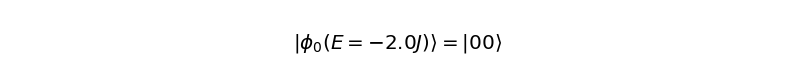

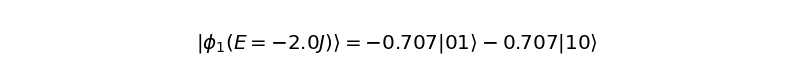

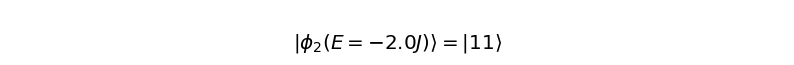

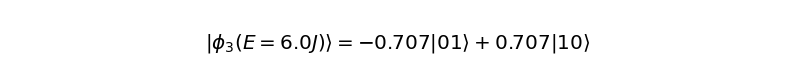

In [2]:
# Number of spins
n_s = 2
# Coupling parameter
J = 1.
# External field / J
g = 0.

# Construct the Hamiltonian matrix
paulis = list()
coeffs = list()
for j in range(n_s):
    paulis.append(list('x' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('y' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('z' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    if g != 0.:
        paulis.append(list('z' if k == j else 'i' for k in range(n_s)))
        coeffs.append(-J * g)

hamiltonian = make_hamiltonian(paulis, coeffs)

# Diagonalize and obtain the eigenvalues and vectors
eigvals, eigvectors = np.linalg.eigh(hamiltonian)

# Print the eigenvectors
for i in range(eigvals.shape[0]):
    show_state(eigvectors[:, i], binary=True, state_label=r'\phi_{} (E={}J)'.format(i, eigvals[i]))

## 問題1: スペクトル推定を実装し、厳密解と照らし合わせる

In [3]:
def trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps):
    """Return a function that implements a single Trotter step for the Heisenberg model.
    
    The Heisenberg model Hamiltonian is
    H = -J * sum_of_sigmas = hbar*ω * Θ
    
    The returned circuit implements a negative time evolution
    U = exp(-i H*(-τ)/hbar)
    where τ = 2π / ω, which leads to
    U = exp(i 2π Θ).
    
    Because we employ the Suzuki-Trotter decomposition, the actual circuit corresponds to
    U = [exp(i 2π/num_steps Θ)]^num_steps.

    Args:
        state_register (QuantumRegister): Register to perform the Suzuki-Trotter simulation.
        energy_norm (float): J/(hbar*ω).
        g (float): External field strength relative to the coupling constant J.
        num_steps (float): Number of steps to divide the time evolution of ωτ=2π.

    Returns:
        QuantumCircuit: A quantum circuit implementing the Trotter simulation of the Heisenberg
        model.
    """
    circuit = QuantumCircuit(state_register, name='ΔU')

    n_spins = state_register.size
    step_size = 2. * np.pi / num_steps

    # Implement the circuit corresponding to exp(i*step_size*Θ) below, where Θ is defined by
    # Θ = -J/(hbar*ω) * sum_of_sigmas = -energy_norm * sum_of_sigmas
    ##################
    ### EDIT BELOW ###
    ##################

    phase = -energy_norm * step_size

    # circuit.?
    for j in range(n_spins):
        # ZZ
        # exp(i dphi ZZ) -> phase +dphi if parity is even
        circuit.cx(j, (j + 1) % n_spins)
        # j + 1 is |0> if parity is even -> apply Rz(-2*dphi) = exp(dphi Z)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)

        # XX
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)

        # YY
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., (j + 1) % n_spins)

        # gZ
        if g != 0.:
            # exp(i dphi gZ)
            circuit.rz(-2. * g * phase, j)

    ##################
    ### EDIT ABOVE ###
    ##################
    
    circuit = circuit.repeat(num_steps)
    circuit.name = 'U'

    return circuit

In [4]:
def spectrum_estimation(state_register, readout_register, u_circuit):
    """Perform a spectrum estimation given a circuit containing state and readout registers and a callable implementing
    a single Trotter step.

    Args:
        state_register (QuantumRegister): State register.
        readout_register (QuantumRegister): Readout register.
        u_circuit (QuantumCircuit): A circuit implementing U_H(-2π/ω).
        
    Returns:
        QuantumCircuit: A circuit implementing the spectrum estimation of the given Hamiltonian.
    """
    circuit = QuantumCircuit(state_register, readout_register, name='Spectrum estimation')

    # Set the R register to an equal superposition
    circuit.h(readout_register)

    # Apply controlled-U operations to the circuit
    for iq, qubit in enumerate(readout_register):
        # Repeat the 2π evolution by 2^iq and convert it to a controlled gate
        controlled_u_gate = u_circuit.repeat(2 ** iq).to_gate().control(1)

        # Append the controlled gate specifying the control and target qubits
        circuit.append(controlled_u_gate, qargs=([qubit] + state_register[:]))
        
    circuit.barrier()

    # Inverse QFT
    for iq in range(readout_register.size // 2):
        circuit.swap(readout_register[iq], readout_register[-1 - iq])

    dphi = 2. * np.pi / (2 ** readout_register.size)

    for jtarg in range(readout_register.size):
        for jctrl in range(jtarg):
            power = jctrl - jtarg - 1 + readout_register.size
            circuit.cp(-dphi * (2 ** power), readout_register[jctrl], readout_register[jtarg])

        circuit.h(readout_register[jtarg])
        
    return circuit

In [5]:
## Physics model parameter
g = 0.

## Spectrum estimation parameters
# Hamiltonian normalization
energy_norm = 1. / 16. # J/(hbar*ω)
# Number of steps per 2pi evolution
# Tune this parameter to find the best balance of simulation accuracy versus circuit depth
num_steps = 6
# Register sizes
n_state = 2
n_readout = 4

## Registers
state_register = QuantumRegister(n_state, 'state')
readout_register = QuantumRegister(n_readout, 'readout')

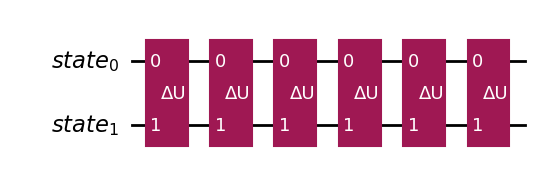

In [6]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
u_circuit.draw('mpl')

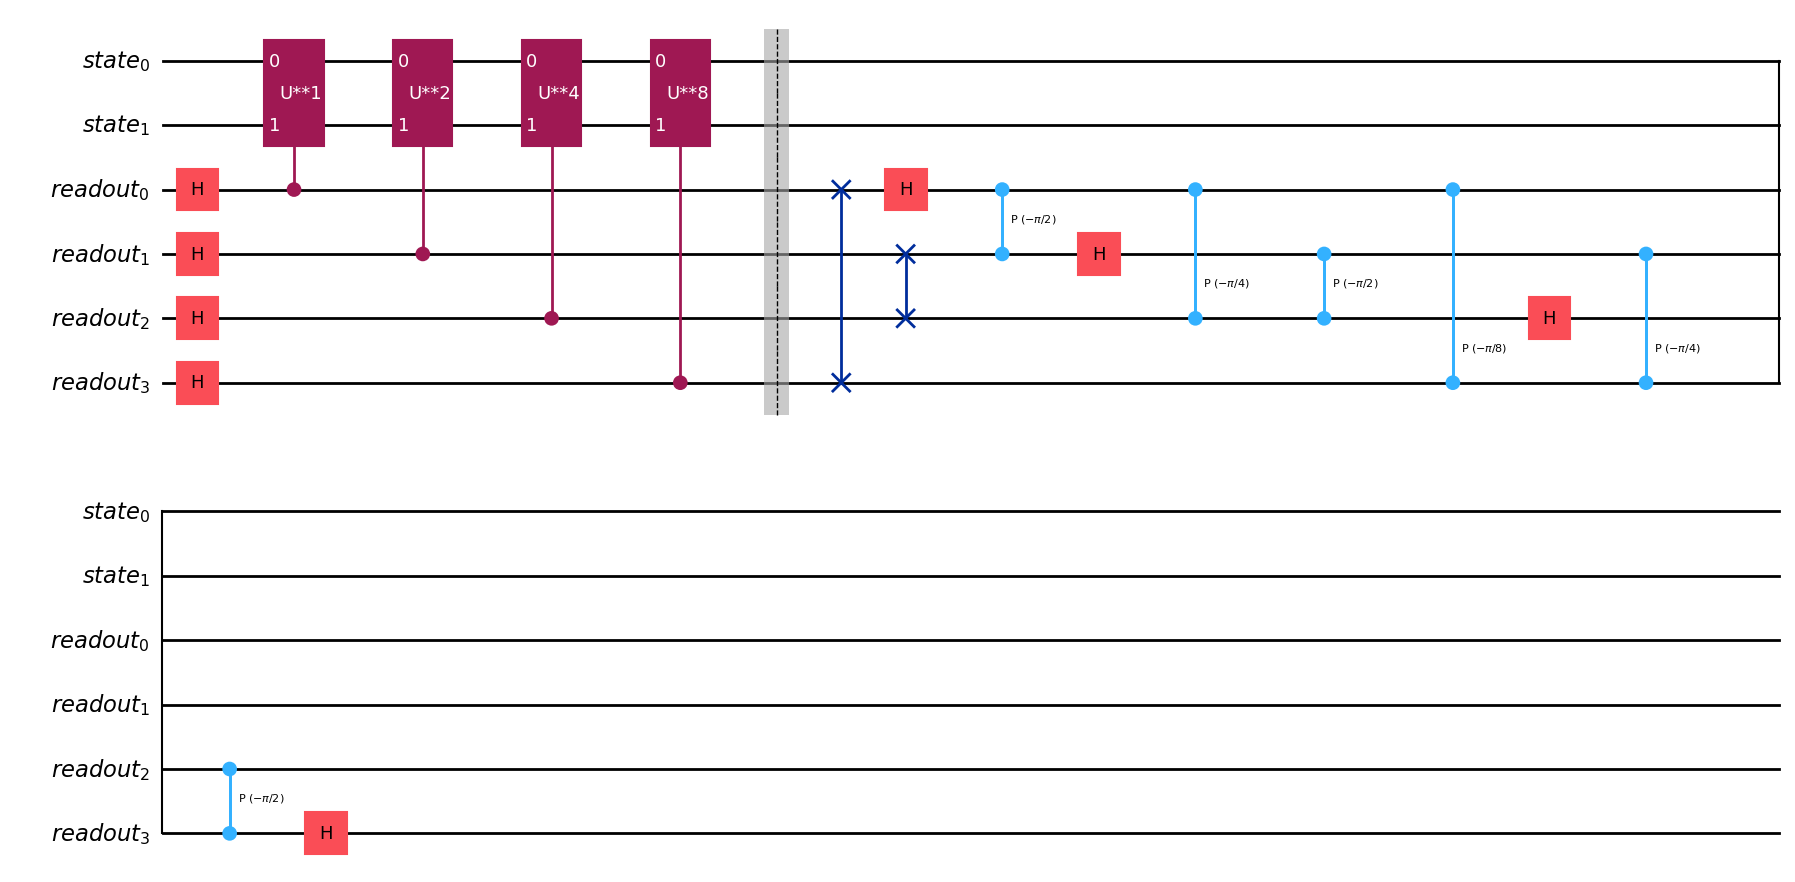

In [7]:
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)
se_circuit.draw('mpl')

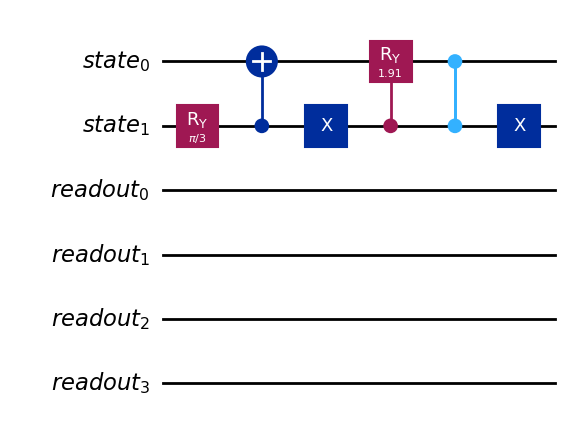

In [8]:
def make_initial_state(state_register, readout_register):
    circuit = QuantumCircuit(state_register, readout_register)

    # Set the initial state of the state vector to (1/2)|00> - (1/sqrt(2))|01> + (1/2)|11>
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?
    circuit.ry(np.pi / 3., state_register[1])
    circuit.cx(state_register[1], state_register[0])
    circuit.x(state_register[1])
    circuit.cry(2. * np.arctan2(np.sqrt(2), 1.), state_register[1], state_register[0])
    circuit.cz(state_register[1], state_register[0])
    circuit.x(state_register[1])

    ##################
    ### EDIT ABOVE ###
    ##################
    
    return circuit


init_circuit = make_initial_state(state_register, readout_register)
init_circuit.draw('mpl')

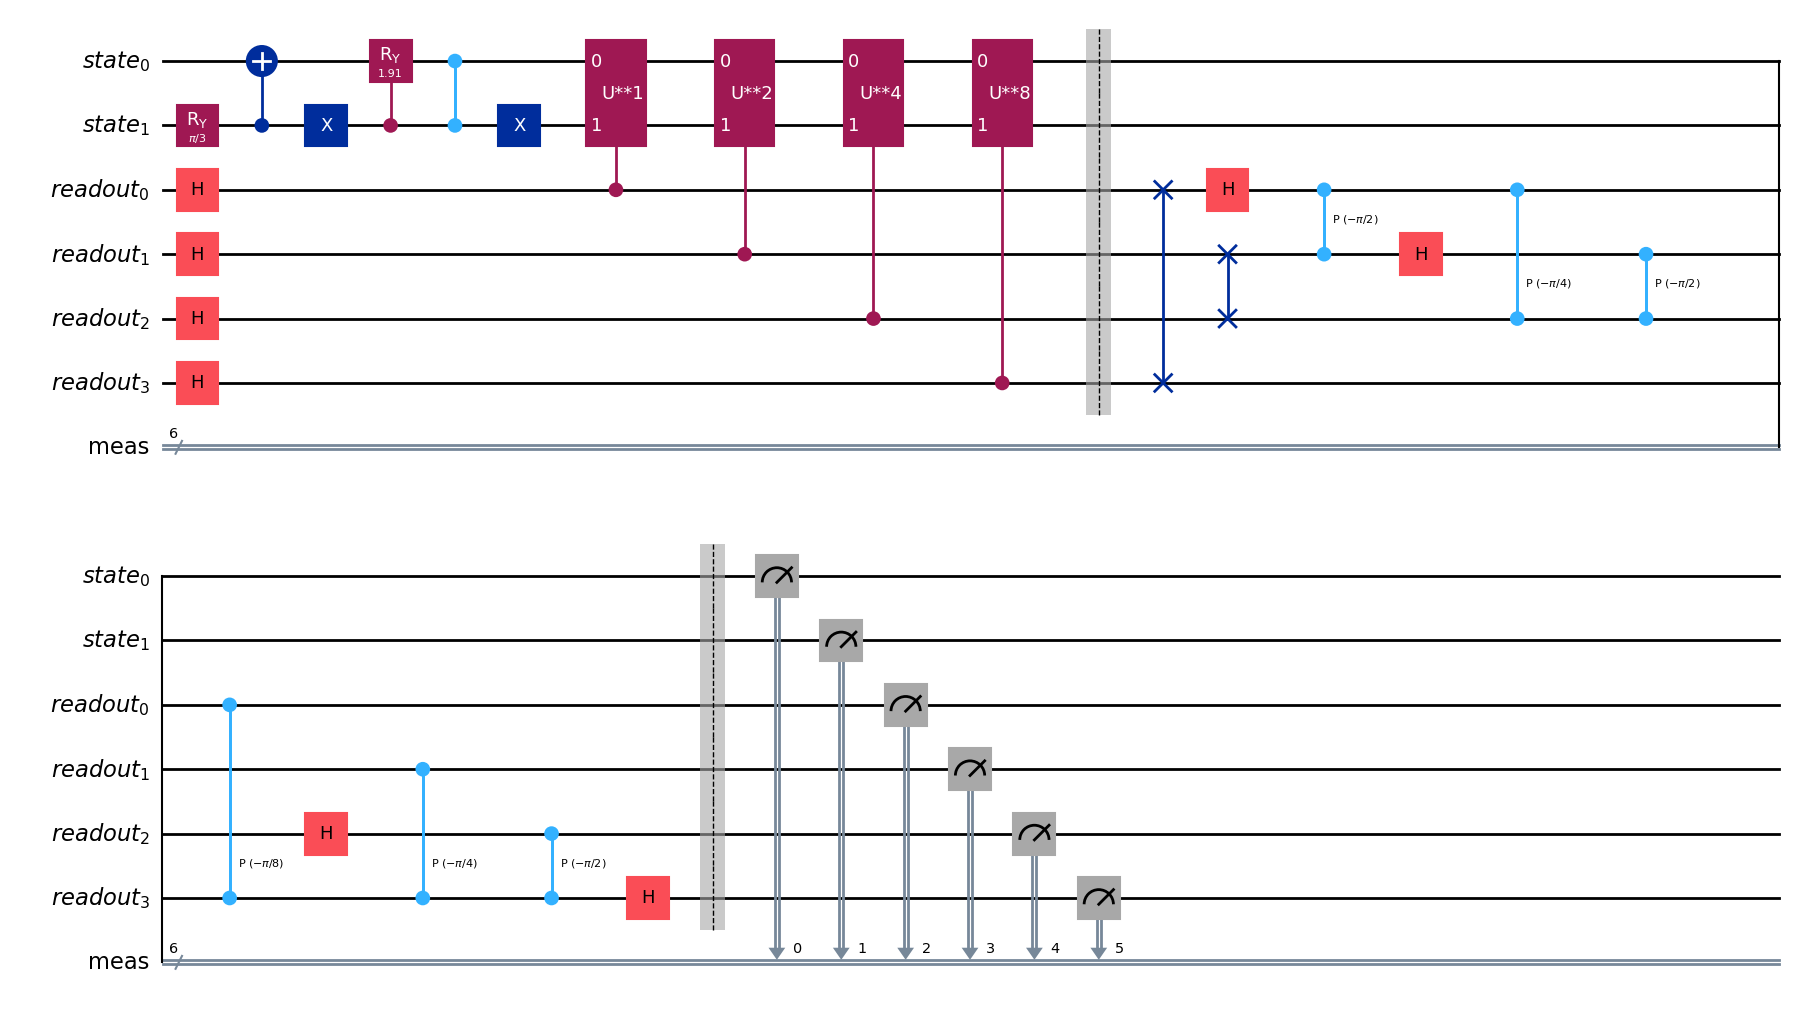

In [9]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

circuit = make_initial_state(state_register, readout_register)
circuit.compose(se_circuit, inplace=True)
circuit.measure_all()
circuit.draw('mpl')

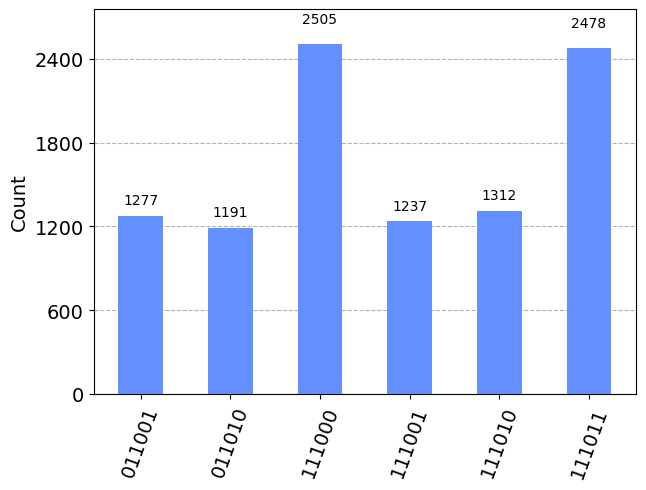

In [10]:
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

**提出するもの**

- 完成した`trotter_twopi_heisenberg`関数
- 完成した状態レジスタの初期化回路
- スペクトル推定の結果のヒストグラムと、その解釈

**スペクトル推定の結果の解釈**

